# 50 Years of Music Trends

## Objective
* Analyze lyrics from billboard top 100 songs over 50 years to identify trends
* Statement: Has the sentiments of popular lyrics changed over time?

## Hypothesis
* Ha = the sentiments of popular lyrics has become more negative over time
* Ho = no change in the sentiments of popular lyrics over time 

## Sources
* musixmatch source: https://developer.musixmatch.com/documentation/api-reference/track-lyrics-get <br/>
* musixmatch python: https://github.com/hudsonbrendon/python-musixmatch <br/>
* billboard python: https://github.com/guoguo12/billboard-charts<br/>

In [1]:
# Dependency library
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import linregress

# API Calls
import billboard
from musixmatch import Musixmatch

# API Keys
from musixmatch_api import api_key

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [2]:
# Generate a (pseudo) random list of (almost all) dates in string format to fit musixmatch parameter

date_list = []
min_year = 1968
error_counter = 0

for i in range(50):
    try:
        # RANDOM date generation
        month_rand = str(random.randint(1,12))
        if len(month_rand) ==1:
            # PAD single digit numbers with a leading 0
            month_rand = month_rand.zfill(2)
            
        day_rand = str(random.randint(1,28))
        if len(day_rand) == 1:
            day_rand = day_rand.zfill(2)
        
        # STRINGIFY the result for the musixmatch parameter
        date_rand = str(f'{min_year}-{month_rand}-{day_rand}')
        
        # APPEND result to date_list
        date_list.append(date_rand)
        
        #INCREMENT the year
        min_year = min_year + 1
        
    except ValueError:
        error_counter = error_counter + 1

# VIEW date_list object
date_list

['1968-03-07',
 '1969-09-09',
 '1970-03-28',
 '1971-11-17',
 '1972-04-27',
 '1973-11-26',
 '1974-03-13',
 '1975-10-25',
 '1976-10-10',
 '1977-05-16',
 '1978-11-09',
 '1979-12-02',
 '1980-11-13',
 '1981-10-14',
 '1982-02-25',
 '1983-05-01',
 '1984-08-04',
 '1985-03-26',
 '1986-01-17',
 '1987-01-25',
 '1988-05-20',
 '1989-09-20',
 '1990-10-17',
 '1991-04-27',
 '1992-03-07',
 '1993-05-03',
 '1994-03-22',
 '1995-04-20',
 '1996-08-27',
 '1997-10-26',
 '1998-07-25',
 '1999-02-24',
 '2000-01-03',
 '2001-12-06',
 '2002-08-20',
 '2003-04-04',
 '2004-06-22',
 '2005-01-24',
 '2006-08-20',
 '2007-07-28',
 '2008-06-24',
 '2009-07-16',
 '2010-03-21',
 '2011-04-07',
 '2012-03-10',
 '2013-04-09',
 '2014-06-27',
 '2015-09-14',
 '2016-01-21',
 '2017-08-02']

In [3]:
# Return top 100 billboard songs for each date in random list generated above
# Note: Running this code takes approximately 2 minutes

billboard_list = 'hot-100'
col_names = ['Song','Artist','Date']
chart_df = pd.DataFrame(columns = col_names)

for date in date_list:
    chart = billboard.ChartData(billboard_list,date)
    for row in chart:
        # EMPTY the list placeholder used to create the dataframe
        chart_list = []
        # CLEAN and convert the billboard object
        chart_list.append(str(row).replace("'","",1))
        temp_df = pd.DataFrame(chart_list)
        temp_df = temp_df[0].str.split("' by ",expand=True)
        temp_df = temp_df.rename(columns={0:"Song",1:"Artist"})
        temp_df['Date'] = date
        
        # APPEND the temp_df in the current loop location to the chart_df
        chart_df = chart_df.append(temp_df)

# REMOVE duplicates and RESET index from the resulting dataframe        
chart_df = chart_df.drop_duplicates().reset_index(drop=True)

# VIEW dataframe head
print(len(chart_df))
chart_df.head()

4999


,Song,Artist,Date
0,Love Is Blue (L'amour Est Bleu),Paul Mauriat And His Orchestra,1968-03-07
1,(Theme From) Valley Of The Dolls,Dionne Warwick,1968-03-07
2,(Sittin' On) The Dock Of The Bay,Otis Redding,1968-03-07
3,Simon Says,1910 Fruitgum Co.,1968-03-07
4,I Wish It Would Rain,The Temptations,1968-03-07


In [4]:
# SPLIT the date values in the dataframe for plotting and analysis purposes

chart_df['Year'], chart_df['Month'], chart_df['Day'] = chart_df['Date'].str.split('-').str

# VIEW dataframe head
chart_df.head()

,Song,Artist,Date,Year,Month,Day
0,Love Is Blue (L'amour Est Bleu),Paul Mauriat And His Orchestra,1968-03-07,1968,03,07
1,(Theme From) Valley Of The Dolls,Dionne Warwick,1968-03-07,1968,03,07
2,(Sittin' On) The Dock Of The Bay,Otis Redding,1968-03-07,1968,03,07
3,Simon Says,1910 Fruitgum Co.,1968-03-07,1968,03,07
4,I Wish It Would Rain,The Temptations,1968-03-07,1968,03,07


In [8]:
# Retrieve lyrics from MusixMatch API based on song and artist in above dataframe
# Running this code takes approximately 5 - 7 minutes

musixmatch = Musixmatch(api_key)
lyrics_list = []
error_counter = 0

# LOOP through the data frame and use song title and artist name to search for lyrics in musixmatch
for x in range(len(chart_df)):
    
    # ERROR HANDLING in case a song queries returns 'null' from musixmatch
    try:
        # GRAB the lyrics based on location (iloc) in chart_df
        song_search = chart_df.iloc[x,0]
        artist_search = chart_df.iloc[x,1]
        lyrics = musixmatch.matcher_lyrics_get(q_artist=artist_search,
                                               q_track=song_search)['message']['body']['lyrics']['lyrics_body']
        
        # FORMATTING to truncate the nonsense at the end of the lyrics from MusixMatch
        song_length = len(lyrics)
        endpoint = len("******* This Lyrics is NOT for Commercial use *******\n(1409617829201)")
        lyrics = lyrics.replace("\n", " ")
        lyrics = str(lyrics[:song_length-endpoint])
        
        # APPEND lyrics to lyrics_list
        lyrics_list.append(lyrics)
        
    except:
        error_counter = error_counter + 1
        lyrics_list.append('MUSIXMATCH_NA')

# CREATE new column in chart_df
chart_df['Lyrics'] = lyrics_list

# VIEW dataframe head
chart_df.head()

,Song,Artist,Date,Year,Month,Day,Lyrics
0,Love Is Blue (L'amour Est Bleu),Paul Mauriat And His Orchestra,1968-03-07,1968,03,07,MUSIXMATCH_NA
1,(Theme From) Valley Of The Dolls,Dionne Warwick,1968-03-07,1968,03,07,"Gotta get off, gonna get Have to get off from ..."
2,(Sittin' On) The Dock Of The Bay,Otis Redding,1968-03-07,1968,03,07,Sittin' in the morning sun I'll be sittin' whe...
3,Simon Says,1910 Fruitgum Co.,1968-03-07,1968,03,07,
4,I Wish It Would Rain,The Temptations,1968-03-07,1968,03,07,"Sunshine, blue skies, please go away My girl h..."


In [80]:
# REMOVE blanks and errors from the dataframe
clean_chart_df = chart_df[(chart_df['Lyrics'] != "MUSIXMATCH_NA") & (chart_df['Lyrics'] != "")].reset_index(drop=True)
# VIEW dataframe head
clean_chart_df.head()
# clean_chart_df.count()

,Song,Artist,Date,Year,Month,Day,Lyrics
0,(Theme From) Valley Of The Dolls,Dionne Warwick,1968-03-07,1968,03,07,"Gotta get off, gonna get Have to get off from ..."
1,(Sittin' On) The Dock Of The Bay,Otis Redding,1968-03-07,1968,03,07,Sittin' in the morning sun I'll be sittin' whe...
2,I Wish It Would Rain,The Temptations,1968-03-07,1968,03,07,"Sunshine, blue skies, please go away My girl h..."
3,Just Dropped In (To See What Condition My Cond...,The First Edition,1968-03-07,1968,03,07,I woke up this morning with the sundown shinin...
4,Spooky,Classics IV,1968-03-07,1968,03,07,In the cool of the evening when ev'rything is ...


In [36]:
# Vader Sentiment Analysis conducted on each song in the dataframe

# INITIALIZE a list to hold the sentiments
lyrics_sentiments = []

# ANALYZE the list
for y in range(len(clean_chart_df)):
    results = analyzer.polarity_scores(clean_chart_df.iloc[y,6])
    compound = results["compound"]
    pos = results["pos"]
    neu = results["neu"]
    neg = results["neg"]
    lyrics_sentiments.append({"Compound": compound,
                              "Positive": pos,
                              "Negative": neg,
                              "Neutral": neu})

# CREATE a dataframe of sentiment analysis that will be appended to the chart_df
lyrics_sentiments_df = pd.DataFrame(lyrics_sentiments)    
    
# APPEND new columns containing the sentiment analysis    
clean_chart_df['Compound'] = lyrics_sentiments_df['Compound']
clean_chart_df['Positive'] = lyrics_sentiments_df['Positive']
clean_chart_df['Negative'] = lyrics_sentiments_df['Negative']
clean_chart_df['Neutral'] = lyrics_sentiments_df['Neutral']

# SAVE to a .csv output
clean_chart_df.to_csv('HA_Sample/billboard_analysis_HA.csv')

# VIEW resulting dataframe head
clean_chart_df.head()

,Song,Artist,Date,Year,Month,Day,Lyrics,Compound,Positive,Negative,Neutral
0,(Theme From) Valley Of The Dolls,Dionne Warwick,1968-03-07,1968,03,07,"Gotta get off, gonna get Have to get off from ...",0.3400,0.050,0.000,0.950
1,(Sittin' On) The Dock Of The Bay,Otis Redding,1968-03-07,1968,03,07,Sittin' in the morning sun I'll be sittin' whe...,0.2960,0.039,0.000,0.961
2,I Wish It Would Rain,The Temptations,1968-03-07,1968,03,07,"Sunshine, blue skies, please go away My girl h...",0.9242,0.279,0.162,0.559
3,Just Dropped In (To See What Condition My Cond...,The First Edition,1968-03-07,1968,03,07,I woke up this morning with the sundown shinin...,0.6808,0.082,0.000,0.918
4,Spooky,Classics IV,1968-03-07,1968,03,07,In the cool of the evening when ev'rything is ...,0.8070,0.139,0.066,0.796


In [37]:
# Create the pandas dataframe group in order to calculate averages by year

chart_group = clean_chart_df.groupby(["Year"]).mean()
chart_group_df = pd.DataFrame(chart_group).reset_index(drop=False)
chart_group_df

,Year,Compound,Positive,Negative,Neutral
0,1968,0.572972,0.170681,0.057986,0.771278
1,1969,0.435672,0.148293,0.059480,0.792253
2,1970,0.391849,0.149074,0.076988,0.774012
3,1971,0.395517,0.155092,0.072987,0.771895
4,1972,0.392946,0.141282,0.064026,0.794641
5,1973,0.537665,0.155146,0.057988,0.786841
6,1974,0.535126,0.157809,0.055674,0.786483
7,1975,0.520266,0.175779,0.062026,0.762195
8,1976,0.509663,0.161642,0.066407,0.771901
9,1977,0.471980,0.145316,0.068797,0.785861


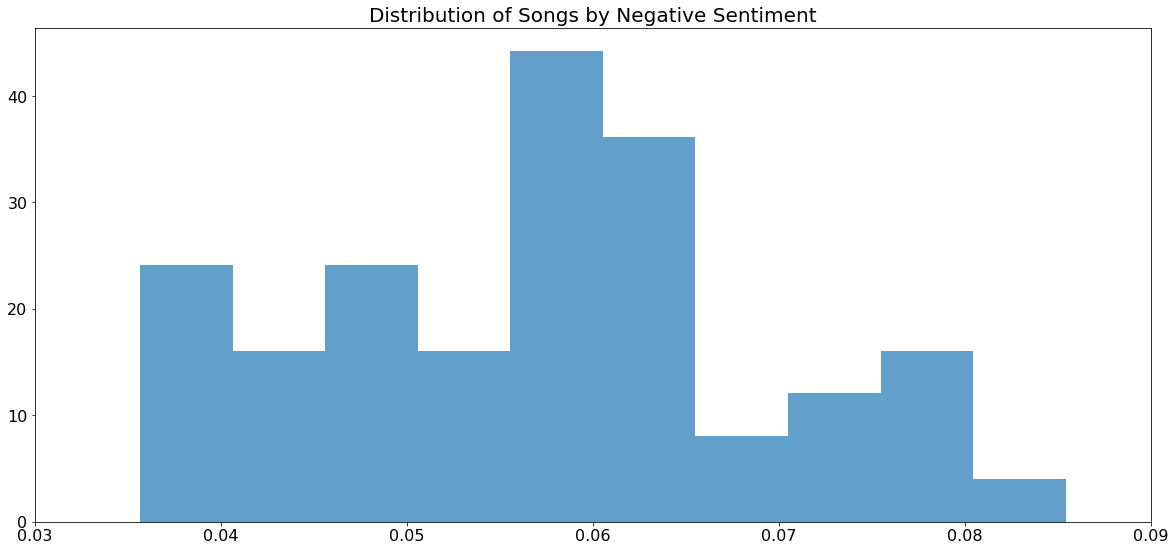

In [74]:
# TEST HISTOGRAM of negative sentiment results

plt.figure(figsize=(20,20))
plt.subplot(2, 1, 2)
plt.hist(chart_group_df['Negative'], 10, density=True, alpha=0.7, label="population1")
x,labels=plt.xticks()
labels=[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11]
plt.xticks(x,labels,fontsize=16)
plt.xticks(label=labels)
plt.yticks(fontsize=16)
plt.title("Distribution of Songs by Negative Sentiment",fontsize=20)

plt.savefig("HA_Sample/histogram.png")

In [75]:
# Create a local x-axis
x_axis = np.arange(1968,2018)
print(len(x_axis))
print(len(chart_group_df['Negative']))

50
50


r = 0.6998454200939533
r^2 = 0.489783612026482
std err = 8.51832698925781e-05
p-value = 1.554264447179865e-08
49% of the variation in the dependent variable (negative sentiment score) is accounted for by the variation in the independent variable (time in years). We feel comfortable using R^2, because the data is approximately normally distributed based on the shape of the histogram (slightly skewed right). Additionally, the p-value is 0+ which is < 0.05. Conclusion: We reject the null hypothesis (Ho) in favor of the alternative. These two variables are strongly related


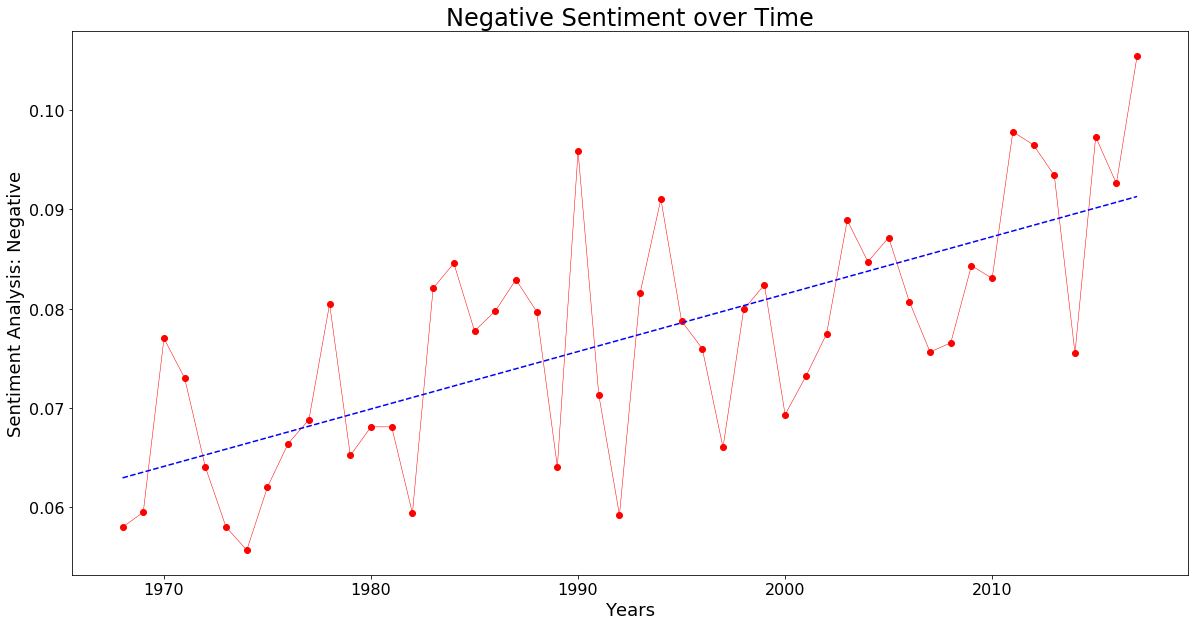

In [76]:
# Scatterplot of negative sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Negative'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel("Years",fontsize=18)
ax.set_ylabel("Sentiment Analysis: Negative",fontsize=18)
ax.tick_params(labelsize=16)
ax.set_title(label="Negative Sentiment over Time",fontsize=24)

# Plots the data
ax.plot(x_axis, chart_group_df['Negative'], marker='o', color=('red'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("HA_Sample/negative.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')
print('49% of the variation in the dependent variable (negative sentiment score) is accounted for by the variation \
in the independent variable (time in years). We feel comfortable using R^2, because the data is approximately \
normally distributed based on the shape of the histogram (slightly skewed right). Additionally, the p-value \
is 0+ which is < 0.05. \
Conclusion: We reject the null hypothesis (Ho) in favor of the alternative. These two variables are strongly related')

r = -0.7008766996937117
r^2 = 0.4912281481735493
std err = 0.00010765141620514461
p-value = 1.4500438763421385e-08


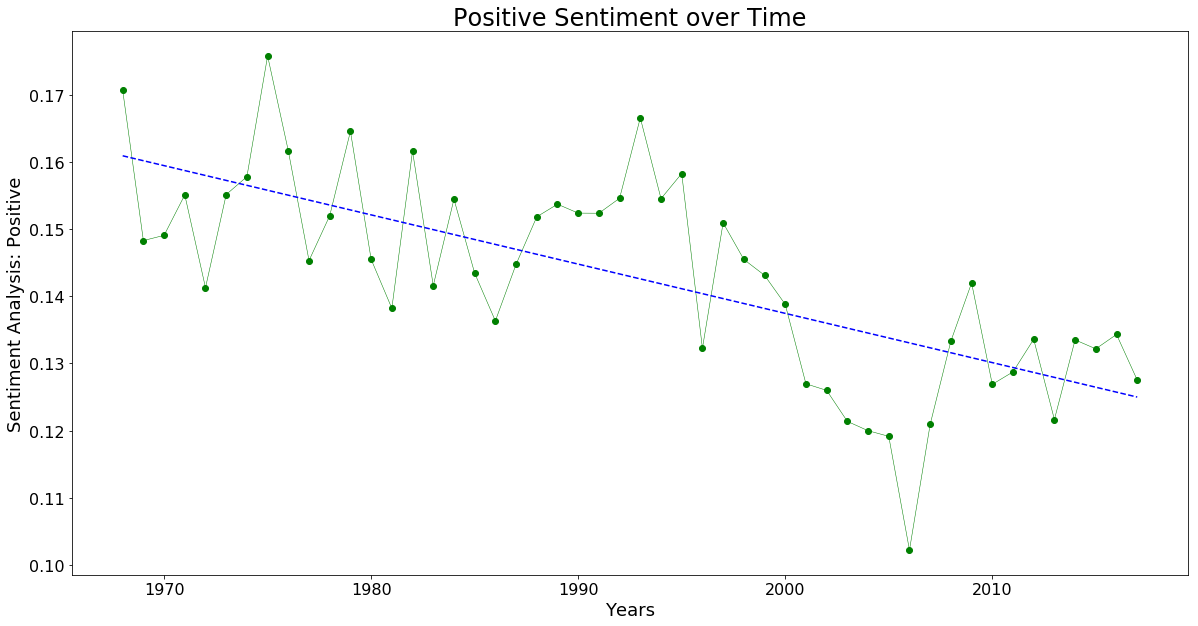

In [77]:
# Scatterplot of positive sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Positive'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel("Years",fontsize=18)
ax.set_ylabel("Sentiment Analysis: Positive",fontsize=18)
ax.tick_params(labelsize=16)
ax.set_title(label="Positive Sentiment over Time",fontsize=24)

# Plots the data
ax.plot(x_axis, chart_group_df['Positive'], marker='o', color=('green'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("HA_Sample/positive.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')

r = 0.16677437766993203
r^2 = 0.02781369304719312
std err = 0.00013231687902760854
p-value = 0.2470377132624296


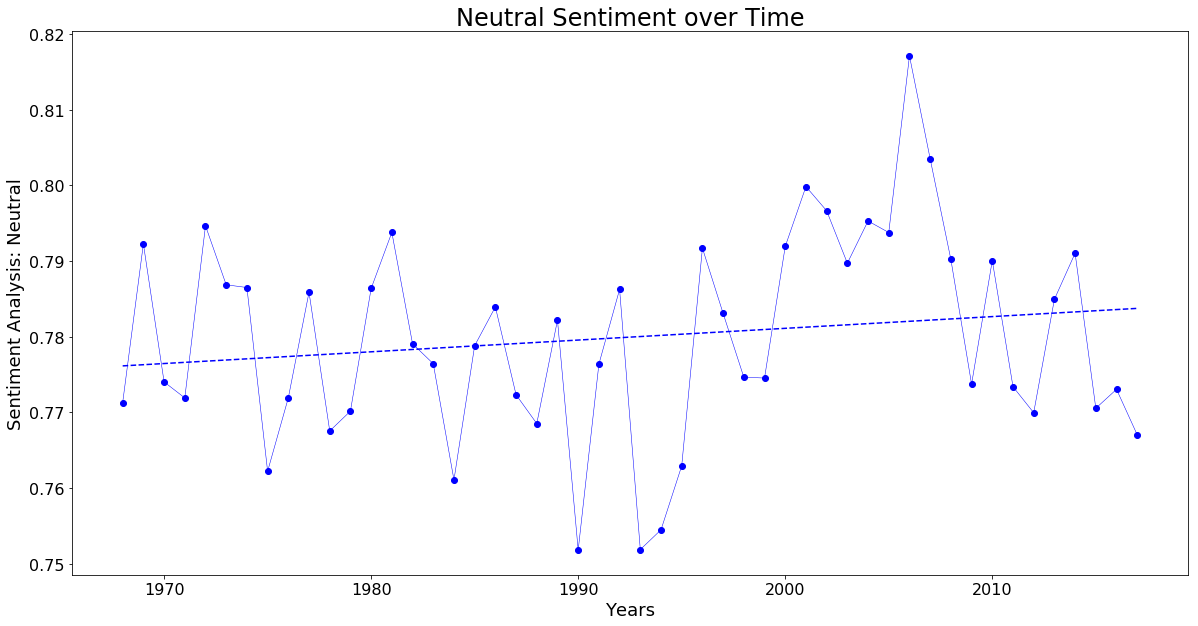

In [78]:
# Scatterplot of neutral sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Neutral'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel("Years",fontsize=18)
ax.set_ylabel("Sentiment Analysis: Neutral",fontsize=18)
ax.tick_params(labelsize=16)
ax.set_title(label="Neutral Sentiment over Time",fontsize=24)

# Plots the data
ax.plot(x_axis, chart_group_df['Neutral'], marker='o', color=('blue'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("HA_Sample/neutral.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')

r = -0.7055791863729157
r^2 = 0.49784198824266573
std err = 0.0007681268409873308
p-value = 1.0527067803812992e-08


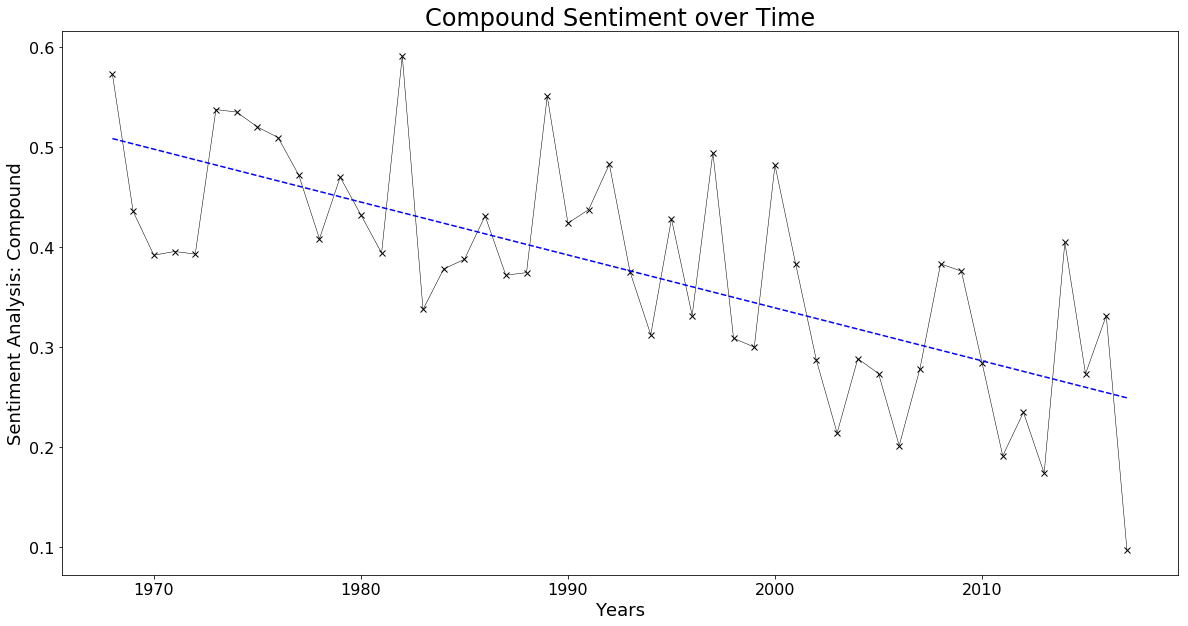

In [79]:
# Scatterplot of compound sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Compound'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel("Years",fontsize=18)
ax.set_ylabel("Sentiment Analysis: Compound",fontsize=18)
ax.tick_params(labelsize=16)
ax.set_title(label="Compound Sentiment over Time",fontsize=24)

# Plots the data
ax.plot(x_axis, chart_group_df['Compound'], marker='x', color=('black'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("HA_Sample/compound.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')